# **Bachelor's Project - CAN Attacks Detection**

Run this in order to connect Google Colab to Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Input Data Analysis


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import matplotlib.cm as cm

In [ ]:
with open('/content/drive/MyDrive/Licenta/canoetrace_1h_CANoe.asc') as f:
    inputdata = f.read()
inputdata=inputdata.lower()
inputlines=inputdata.splitlines()
inputlines=inputlines[4:-1]

inputlines[-1]
#print(len(inputlines))


'3489.968538  1  5dd rx  d  3  00 00 00 '

In [ ]:
temp=[]
for line in inputlines:
  line=line.split()
  message_length=int(line[5])
  if(message_length<8):
    for i in range(8-message_length):
      line.insert(6+message_length+i,'00')
  temp.append(line)
inputdata=temp

In [ ]:
inputdata = pd.DataFrame(inputdata, columns=['Time', 'Channel','ID','Type','d','ByteNo','b1','b2','b3','b4','b5','b6','b7','b8'])

In [ ]:
inputdata=inputdata.drop('Channel',axis=1)
inputdata=inputdata.drop('d',axis=1)
inputdata=inputdata.drop('Type',axis=1)
inputdata[['b1','b2','b3','b4','b5','b6','b7','b8']]=inputdata[['b1','b2','b3','b4','b5','b6','b7','b8']].applymap(lambda x: int(x, 16))
inputdata[['ID']]=inputdata[['ID']].applymap(lambda x:int(x,16))
inputdata['Time']=inputdata['Time'].astype(float)

In [ ]:
inputdata[:10]

,Time,ID,ByteNo,b1,b2,b3,b4,b5,b6,b7,b8
2140380,3489.947632,385,8,0,0,51,16,50,9,97,76
2140381,3489.957372,353,5,17,3,62,0,16,0,0,0
2140382,3489.957577,505,6,2,30,0,0,248,0,0,0
2140383,3489.957814,385,8,0,0,51,16,50,9,97,76
2140384,3489.967481,353,5,17,3,62,0,16,0,0,0
2140385,3489.967710,1361,8,117,206,100,8,255,112,0,236
2140386,3489.967915,505,6,2,30,0,0,248,0,0,0
2140387,3489.968153,385,8,0,0,51,16,50,9,97,76
2140388,3489.968382,1297,7,0,0,0,0,0,0,0,0
2140389,3489.968538,1501,3,0,0,0,0,0,0,0,0


In [ ]:
IDs = inputdata.groupby(['ID'])['ID'].count().reset_index(name='Count')
IDs

,ID,Count
0,353,348570
1,385,348570
2,421,347303
3,505,348570
4,580,173700
5,644,173700
6,645,173700
7,852,86850
8,1297,34857
9,1361,34857


Text(0.5, 1.0, 'Messages percentage on CAN Trace')

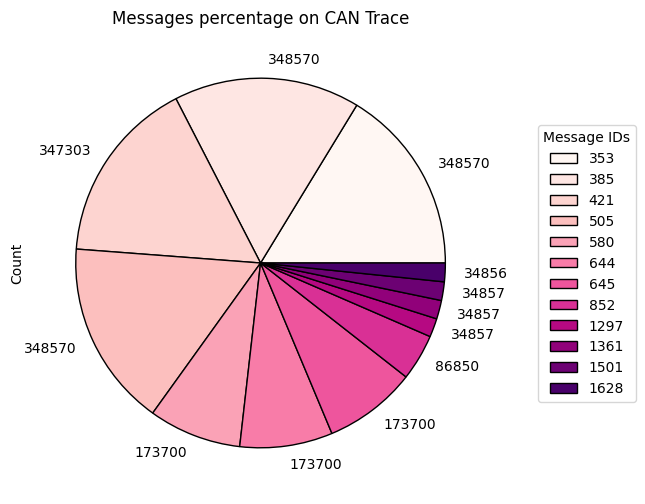

In [ ]:
plot = IDs.plot.pie(y='Count',labels=IDs['Count'], figsize=(6,10),cmap=mpl.colormaps['RdPu'],shadow=False,wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'})
plt.legend(IDs['ID'], loc=(1, 0.2),title='Message IDs')
plt.title('Messages percentage on CAN Trace')

In [ ]:
def CycleTimePlots(ids):
  fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 20))
  fig.tight_layout(pad=2)
  colormap = mpl.colormaps['RdPu']
  colors = [colormap(i / len(ids)) for i in range(len(ids))]
  for index, id in enumerate(ids):
    message=inputdata[inputdata['ID']==id]
    random_number=random.randint(1, 3400)
    message=message[random_number:random_number+15]
    x=message['Time']
    y=message['ByteNo']

    for entry in x:
      axes[index].axvline(x=entry, color='black', linewidth=4, linestyle='solid')
      axes[index].axvline(x=entry, color=colors[index], linewidth=3, linestyle='solid')
    lowerlimit=x.iloc[0]
    upperlimit=x.iloc[-1]
    axes[index].set_xlim(lowerlimit, upperlimit)
    axes[index].set_xticks(x)
    axes[index].set_title(f"Cycle time plot for ID: {id}")


  plt.show()

In [ ]:
def DiffHistogram(ids):
  fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
  fig.tight_layout(pad=2)
  colormap = mpl.colormaps['RdPu']
  colors = [colormap(i / len(ids)) for i in range(len(ids))]
  for index, id in enumerate(ids):
    i=int(index/4)
    j=int(index%4)
    message = inputdata[inputdata['ID'] == id].copy()
    message['Diff']=message['Time'].diff()
    axes[i, j].hist(message['Diff'],color=colors[index], bins=10,edgecolor='black')
    axes[i, j].set_title(f"Histogram for ID: {id}")

  plt.show()


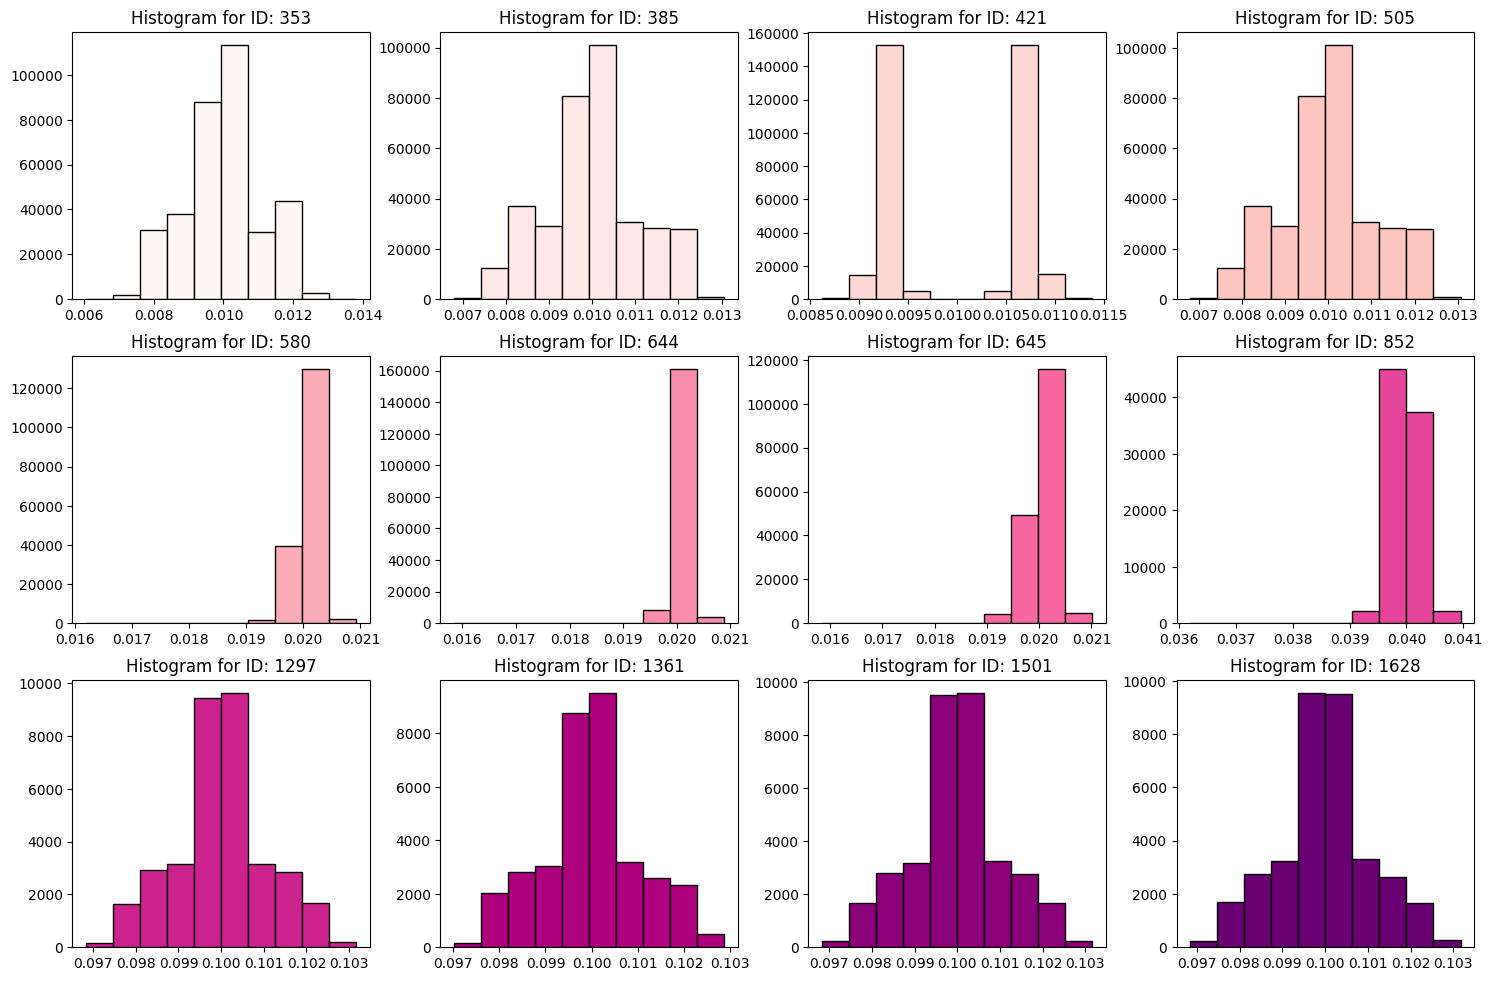

In [ ]:
DiffHistogram(IDs['ID'])

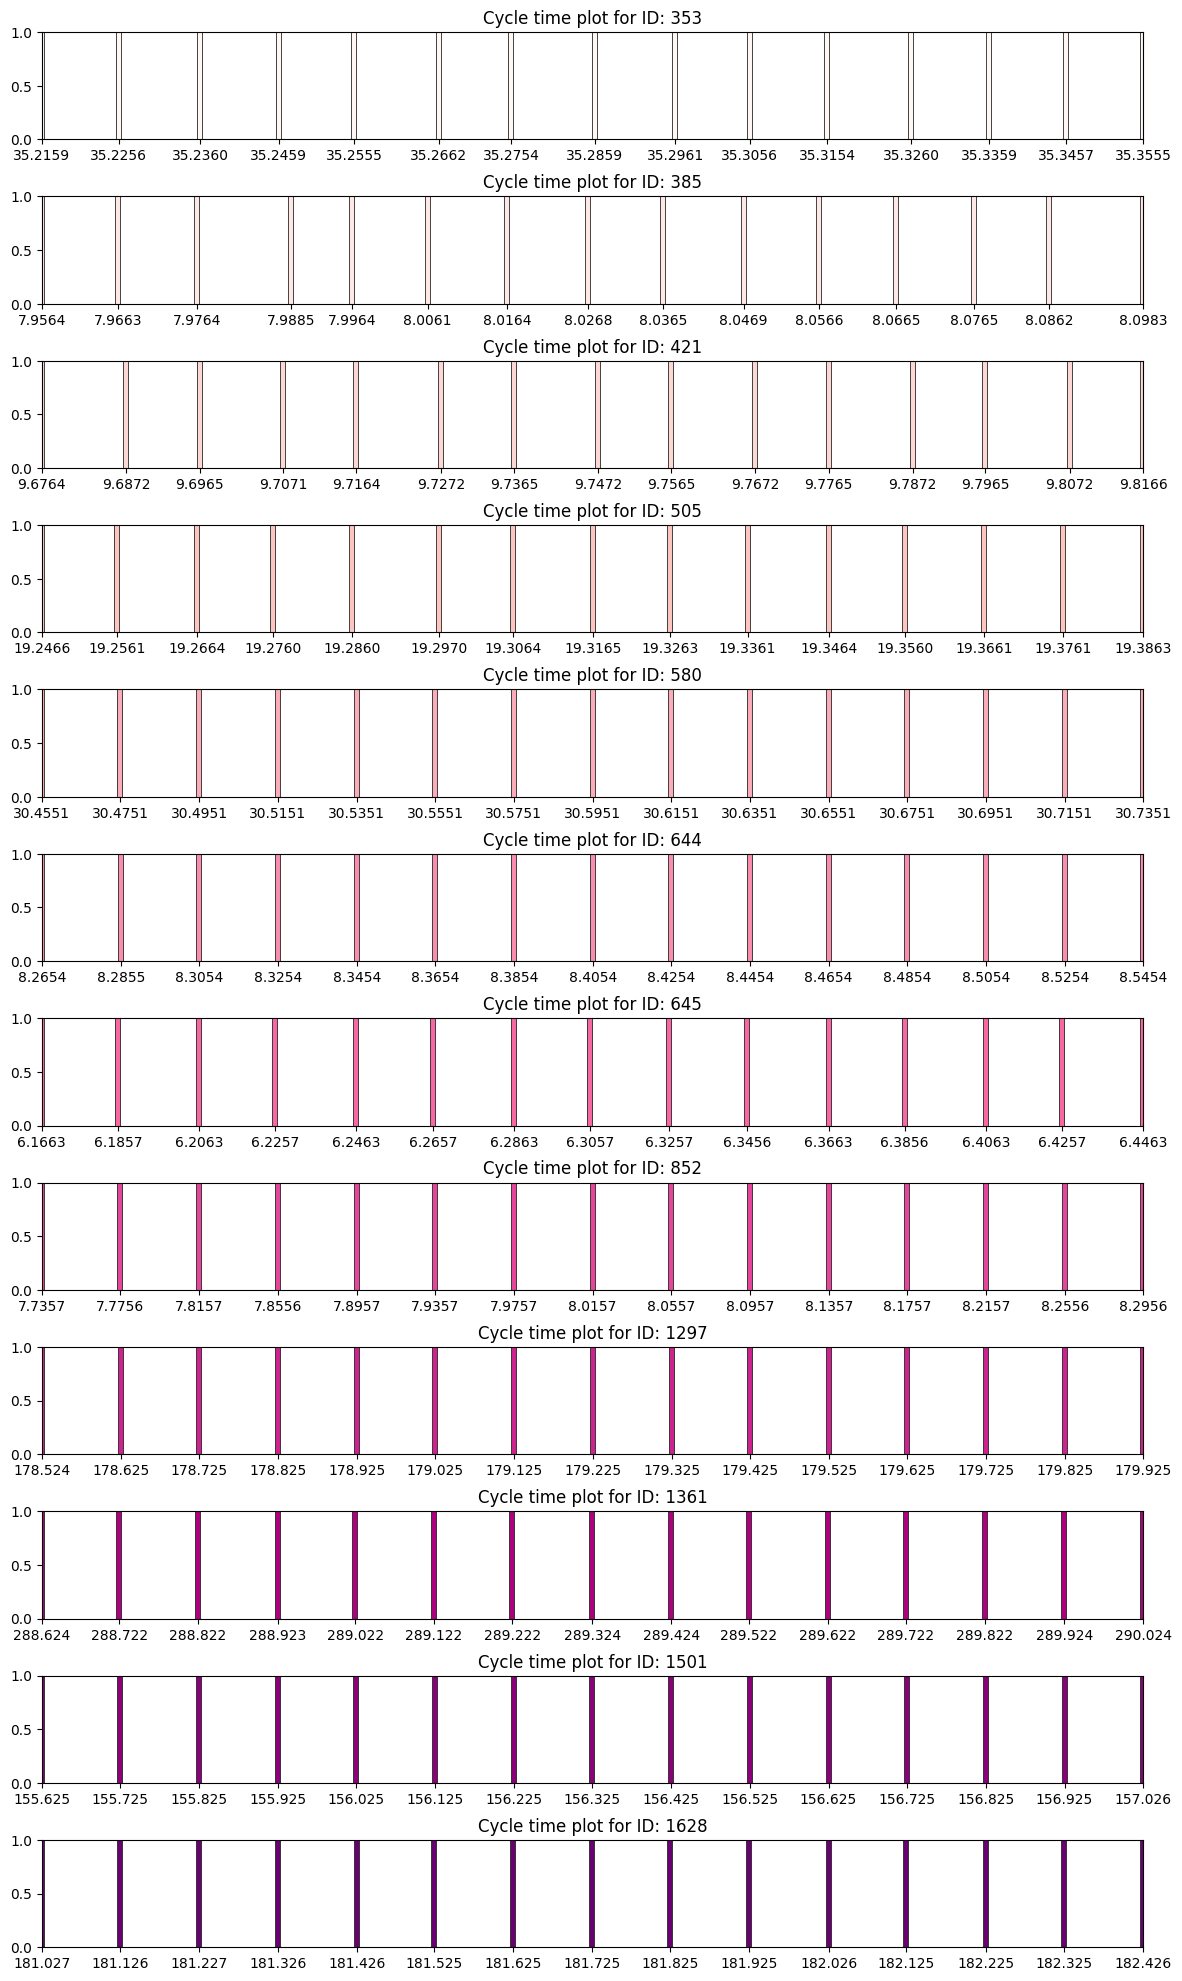

In [ ]:
CycleTimePlots(IDs['ID'])

## Data Cleaning & Dataset Creation

Handling labels. Cleaned data. Removed description of data. Splitting lines in 'words'. Adding extra '00' bytes as padding for messages that have length smaller than 8.
For the final data structure we'll have the following format:
1.  Time       
6.  LengthOfMessage   
7.  Byte1   
8.  Byte2   
9.  Byte3   
10. Byte4   
11. Byte5   
12. Byte6   
13. Byte7   
14. Byte8
15. MessageID(decimal)

In [ ]:
import numpy as np
import pandas as pd
from numpy import genfromtxt

In [ ]:
def readLabels(filename):
  with open(filename) as f:
    output = f.read()
  output=output.lower()
  labels=output.splitlines()
  print('Labels length:' +str(len(labels)))
  return labels

In [ ]:
def readData(filename):
  with open(filename) as f:
    trace = f.read()
  trace=trace.lower()
  trace=trace.splitlines()
  trace=trace[5:]
  data=[]
  print('Trace length:' +str(len(trace)))
  for line in trace:
    line=line.replace("length","")
    line=line.replace("=","")
    line=line.replace("bitcount","")
    line=line.replace("id","")
    if "error" not in line:
      data.append(line)
  print('Data length:' +str(len(data)))
  return data

In [ ]:
def splitBytes(data):
  prevline=[]
  temp=[]
  for line in data:
    line=line.split()
    message_length = int(line[5])
    if(message_length<8):
      for i in range(8-message_length):
        line.insert(6+message_length+i,'00')
    temp.append(line)
    prevline=line
  data=temp
  return data

#  print(data[:5])

In [ ]:
def createDataset(data,labels):
  data = pd.DataFrame(data, columns=['Time', 'Channel','ID_Hex','Type','???','ByteNo','b1','b2','b3','b4','b5','b6','b7','b8','Length','Bitcount','ID'])
  data=data.drop('Channel',axis=1)
  data=data.drop('???',axis=1)
  data=data.drop('ID_Hex',axis=1)
  data=data.drop('Type',axis=1)
  data=data.drop('Bitcount',axis=1)
  data=data.drop('Length' ,axis=1)
  data[['b1','b2','b3','b4','b5','b6','b7','b8']]=data[['b1','b2','b3','b4','b5','b6','b7','b8']].applymap(lambda x: int(x, 16))
  data[['ByteNo','ID']]=data[['ByteNo','ID']].applymap(lambda x:int(x,10))
  data['Time']=data['Time'].astype(float)
  data=np.array(data)
  labels=np.array(labels)
  return data,labels

In [ ]:
def saveOnDrive(data,labels,path_data,path_labels):
  fmt='%f, %d, %d, %d, %d, %d, %d, %d, %d, %d, %d'
  np.savetxt(path_data, data, fmt=fmt, delimiter=',')
  labels = np.where(labels == 'intrusion', 1, 0)
  np.savetxt(path_labels, labels, fmt='%d')

In [ ]:
def processInput(filename_data,filename_labels,destination_data,destination_labels):
  data=[]
  labels=[]
  labels=readLabels(filename_labels)
  data=readData(filename_data)
  data=splitBytes(data)
  data,labels=createDataset(data,labels)
  saveOnDrive(data,labels,destination_data,destination_labels)

Created datasets for every type of data that I have & saved them on drive for easier access:

1) Replay Attacks Dataset - contains a CAN trace that have replay attacks (30% probability)

2) Fuzzing Attacks Dataset - contains a CAN trace that have fuzzing attacks (30% probability)

3) General Attacks Dataset - contains a CAN trace that have both replat and fuzzing attacks (15% probability each)

In [ ]:
#replay
processInput('/content/drive/MyDrive/Licenta/Replay.asc','/content/drive/MyDrive/Licenta/ReplayLabels.txt','/content/drive/MyDrive/Licenta/Replay.csv','/content/drive/MyDrive/Licenta/ReplayLabels.csv')
#fuzzing
processInput('/content/drive/MyDrive/Licenta/Fuzzing.asc','/content/drive/MyDrive/Licenta/FuzzingLabels.txt','/content/drive/MyDrive/Licenta/Fuzzing.csv','/content/drive/MyDrive/Licenta/FuzzingLabels.csv')
#general
processInput('/content/drive/MyDrive/Licenta/Attack.asc','/content/drive/MyDrive/Licenta/AttackLabels.txt','/content/drive/MyDrive/Licenta/Attack.csv','/content/drive/MyDrive/Licenta/AttackLabels.csv')

Labels length:2426945
Trace length:2430442
Data length:2426945
Labels length:2489513
Trace length:2493002
Data length:2489513
Labels length:2714060
Trace length:2718261
Data length:2714060


##Classification

In [13]:
from numpy import genfromtxt

In [12]:
def getFromDrive(path_data,path_labels):
  data = genfromtxt(path_data, delimiter=',')
  labels = genfromtxt(path_labels, delimiter=',')
  return data,labels

In [27]:
#replay attacks dataset
data_replay,labels_replay=getFromDrive('/content/drive/MyDrive/Licenta/Replay.csv','/content/drive/MyDrive/Licenta/ReplayLabels.csv')
#fuzzing attacks dataset
data_fuzzing,labels_fuzzing=getFromDrive('/content/drive/MyDrive/Licenta/Fuzzing.csv','/content/drive/MyDrive/Licenta/FuzzingLabels.csv')
#general attacks dataset
data,labels=getFromDrive('/content/drive/MyDrive/Licenta/Attack.csv','/content/drive/MyDrive/Licenta/AttackLabels.csv')

###Functions

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib as mpl
import pandas as pd
from keras.models import load_model


In [4]:
types=['KNN', 'MLP', 'LSTM']

In [5]:
def KNNClassification(X_train,y_train,X_test,y_test):
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  print("kNN model accuracy:", metrics.accuracy_score(y_test, y_pred))
  return y_pred

In [6]:
def MLPClassification(X_train, y_train, X_test, y_test):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    scaler = preprocessing.StandardScaler().fit(X_resampled)
    X_train_scaled = scaler.transform(X_resampled)
    X_test_scaled = scaler.transform(X_test)

    clf = MLPClassifier(
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        learning_rate_init=0.01,
        max_iter=50,
        alpha=0.0001,
        hidden_layer_sizes=(10, 10, 10,10,10),
        batch_size=256,
        verbose=False,
        early_stopping=True,
        n_iter_no_change=10,
        tol=1e-4)

    clf.fit(X_train_scaled, y_resampled)
    y_pred = clf.predict(X_test_scaled)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("MLP model accuracy:", accuracy)

    return y_pred

In [7]:
def save_model(model,model_path):
  model.save(model_path)
  model.save('model.h5',save_format='h5')
  print('Model saved successfully')

def load_from_drive(model_path):
  model = load_model(model_path)
  print('Model loaded successfully')
  return model

In [45]:
def LSTMClassification(X_train, y_train, X_test, y_test, load=True,path='/content/drive/MyDrive/Licenta/model_general_lstm.h5'):
    if load:
        model = load_from_drive(path)
    else:
        # Handle class imbalance with SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        X_resampled = X_resampled.reshape((X_resampled.shape[0], X_resampled.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        max_features = 3600
        maxlen = X_resampled.shape[1]
        embedding_dim = 32
        hidden_units = 50

        model = Sequential()
        model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
        model.add(LSTM(hidden_units))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(X_resampled, y_resampled, epochs=20, batch_size=256, validation_split=0.2,  callbacks=[early_stopping])
        model.summary()
        save_model(model, path)

    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model.predict(X_test)
    y_pred = (y_pred >= 0.5).astype(int)
    print("LSTM model accuracy:", metrics.accuracy_score(y_test, y_pred))

    return y_pred

In [9]:
def showDetails(y_test,y_preds):
  details = pd.DataFrame([], columns=['Type', 'TN','FP','FN','TP'])

  for i, y_pred in enumerate(y_preds):
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    true_negative = confusion_matrix[0][0]
    false_positive = confusion_matrix[0][1]
    false_negative = confusion_matrix[1][0]
    true_positive = confusion_matrix[1][1]
    new_row = {"Type": types[i], "TN": true_negative, "FP": false_positive, "FN": false_negative, "TP": true_positive}
    #details=details.append(new_row, ignore_index=True)
    details = pd.concat([details, pd.DataFrame([new_row])], ignore_index=True)


  details['TPR'] = details['TP']/(details['TP']+details['FN'])   #true positive rate
  details['TNR'] = details['TN']/(details['TN']+details['FP'])   #true negative rate
  details['PPV'] = details['TP']/((details['TP']+details['FP']).replace(0,-1)) #positive predictive value / precision
  details['NPV'] = details['TN']/((details['TN']+details['FN']).replace(0, -1))   #negative predictive value
  details['FNR'] = details['FN']/(details['FN']+details['TP'])  #false negative rate
  details['FPR'] = details['FP']/(details['FP']+details['TN'])  #false positive rate
  details['FDR'] = details['FP']/((details['FP']+details['TP']).replace(0,-1))  #false discovery rate
  details['FOR'] = details['FN']/(details['FN']+details['TN'])  #false omission rate
  details['LRP'] = details['TPR']/(details['FPR'].replace(0,-1)) #positive likelihood ratio
  details['LRM'] = details['FNR']/details['TNR'] #negative likelihood ratio
  details['TS']=details['TP']/(details['TP']+details['FN']+details['FP']) #threat score/critical success index
  details['ACC']=(details['TP']+details['TN'])/(details['TP']+details['TN']+details['FP']+details['FN']) #accuracy

  #print(details)
  fig, ax = plt.subplots(figsize=(20, 4))
  ax.axis('tight')
  ax.axis('off')
  table = ax.table(cellText=details.applymap(lambda x: f"{x:.3f}" if isinstance(x, float) else x).values, colLabels=details.columns, loc='center', cellLoc='center')
  table.auto_set_font_size(False)
  table.set_fontsize(10)
  table.scale(1, 1.5)  # Adjust the scaling as needed
  plt.show()



In [10]:
def PlotConfusionMatrices(y_test,y_preds):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
  fig.tight_layout(pad=6)
  colormap = mpl.colormaps['RdPu']
  for i, pred in enumerate(y_preds):
    confusion_matrix = metrics.confusion_matrix(y_test, pred)
    metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]).plot(cmap=colormap,ax=axes[i])
    axes[i].set_title(f"CM for {types[i]}")

  plt.show()


### Fuzzing Attacks

In [28]:
X_train_fuzzing, X_test_fuzzing, y_train_fuzzing, y_test_fuzzing = train_test_split(data_fuzzing,labels_fuzzing, test_size=0.2, random_state=0)

In [23]:
y_pred_fuzzing_KNN=KNNClassification(X_train_fuzzing, y_train_fuzzing,X_test_fuzzing, y_test_fuzzing)

kNN model accuracy: 0.9983651434114676


In [24]:
y_pred_fuzzing_MLP=MLPClassification(X_train_fuzzing, y_train_fuzzing,X_test_fuzzing, y_test_fuzzing)

MLP model accuracy: 0.9995963069111855


In [47]:
y_pred_fuzzing_LSTM=LSTMClassification(X_train_fuzzing, y_train_fuzzing,X_test_fuzzing, y_test_fuzzing,load=True,path='/content/drive/MyDrive/Licenta/model_fuzzing_lstm.h5')

Model loaded successfully
15560/15560 [==============================] - 34s 2ms/step
LSTM model accuracy: 0.9999136377969203


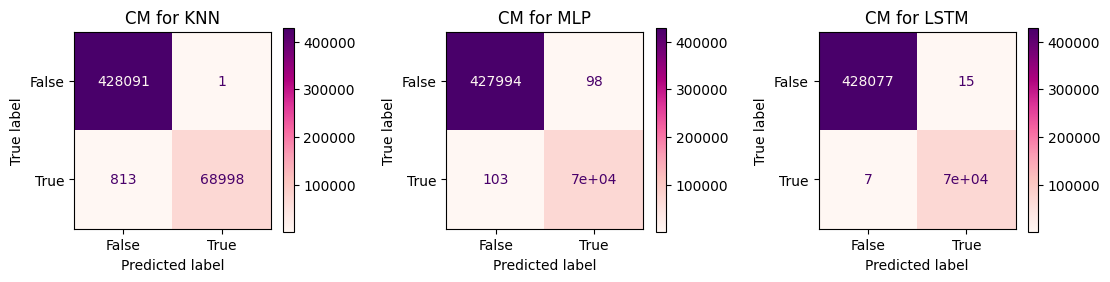

In [25]:
preds=[y_pred_fuzzing_KNN, y_pred_fuzzing_MLP, y_pred_fuzzing_LSTM]
PlotConfusionMatrices(y_test_fuzzing, preds)

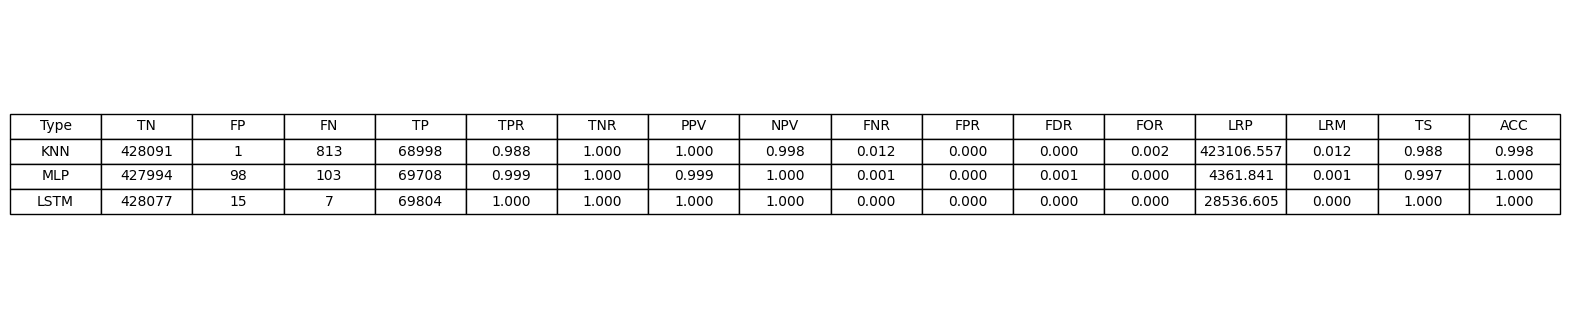

In [26]:
showDetails(y_test_fuzzing, preds)

### Replay Attacks

In [31]:
X_train_replay, X_test_replay, y_train_replay, y_test_replay = train_test_split(data_replay,labels_replay, test_size=0.2, random_state=0)

In [49]:
y_pred_replay_KNN=KNNClassification(X_train_replay, y_train_replay,X_test_replay, y_test_replay)

kNN model accuracy: 0.8743420225839481


In [50]:
y_pred_replay_MLP=MLPClassification(X_train_replay, y_train_replay,X_test_replay, y_test_replay)

MLP model accuracy: 0.3941024621489156


In [55]:
y_pred_replay_LSTM=LSTMClassification(X_train_replay, y_train_replay,X_test_replay, y_test_replay,load=True,path='/content/drive/MyDrive/Licenta/model_replay_lstm.keras')

Model loaded successfully
15169/15169 [==============================] - 35s 2ms/step
LSTM model accuracy: 0.837052343584218


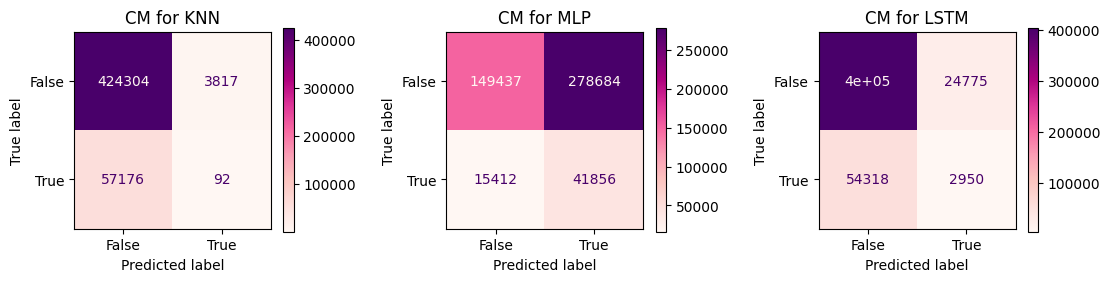

In [56]:
preds=[y_pred_replay_KNN, y_pred_replay_MLP, y_pred_replay_LSTM]
PlotConfusionMatrices(y_test_replay, preds)

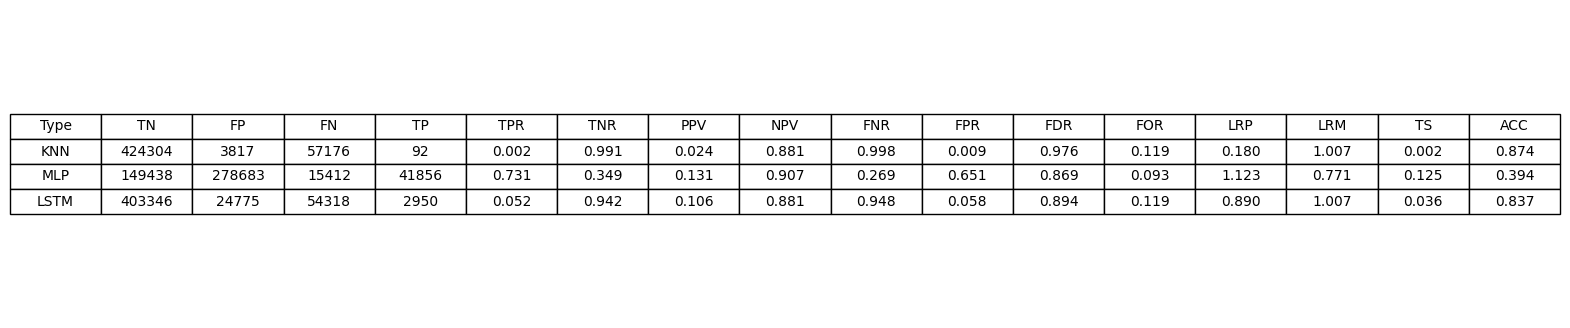

In [56]:
showDetails(y_test_replay, preds)

### General Attacks

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=0.2, random_state=0)

In [38]:
y_pred_KNN=KNNClassification(X_train, y_train,X_test, y_test)

kNN model accuracy: 0.8857836599043499


In [41]:
y_pred_MLP=MLPClassification(X_train, y_train,X_test, y_test)

MLP model accuracy: 0.8931913811780138


In [57]:
y_pred_LSTM=LSTMClassification(X_train, y_train,X_test, y_test,load=True,path='/content/drive/MyDrive/Licenta/model_general_lstm.h5')

Model loaded successfully
16963/16963 [==============================] - 52s 3ms/step
LSTM model accuracy: 0.8936353654672335


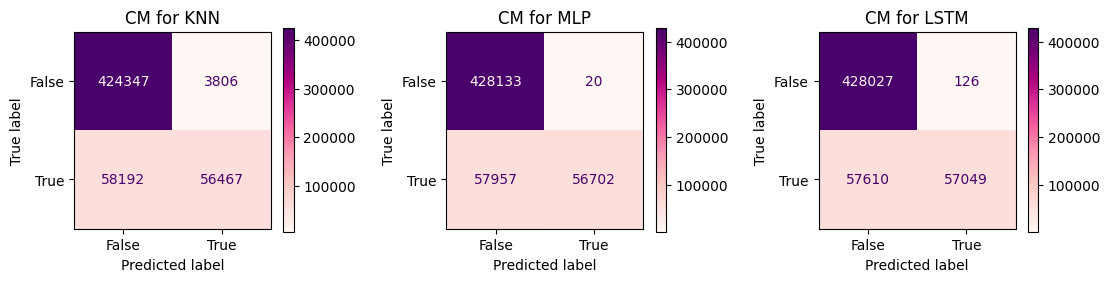

In [42]:
preds=[y_pred_KNN, y_pred_MLP, y_pred_LSTM]
PlotConfusionMatrices(y_test, preds)

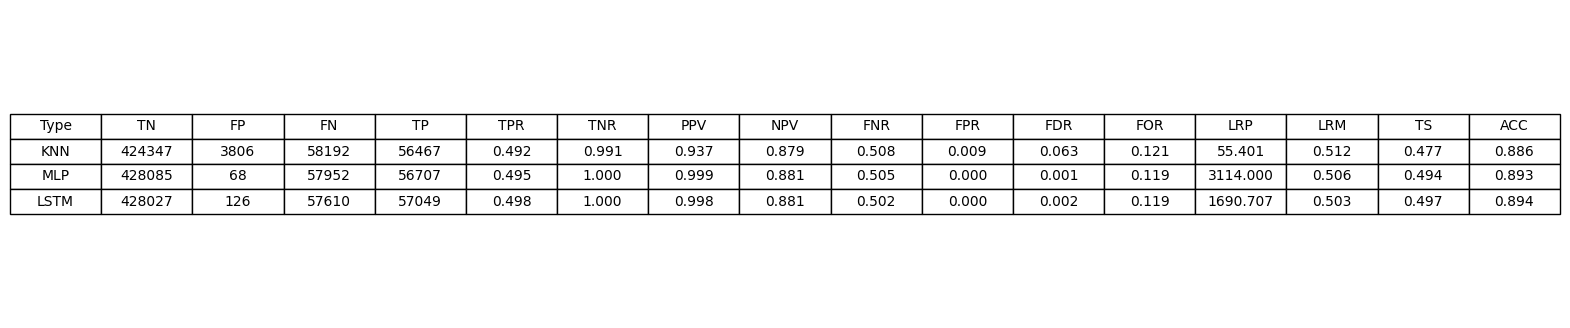

In [52]:
showDetails(y_test, preds)

## Convert keras model -> TensorFlow Lite Model

In [23]:
pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.6 MB/s eta 0:00:00


In [24]:
import tensorflow as tf
import keras
from keras.models import load_model
import tflite_runtime
import flatbuffers

In [ ]:
print(tf.__version__)
print(keras.__version__)
print(tflite_runtime.__version__)
print(flatbuffers.__version__)

2.15.0
2.15.0
2.14.0
24.3.25


In [37]:
def convert_to_tflite(path_h5,path_tflite):
  keras_model = load_model(path_h5)
  converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.experimental_new_converter=True
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS]
  tflite_model = converter.convert()

  with open(path_tflite, 'wb') as f:
    f.write(tflite_model)

convert_to_tflite('/content/drive/MyDrive/Licenta/model_general_lstm.h5', '/content/drive/MyDrive/Licenta/model.tflite')

## Tests for integrating code on RPI

In [ ]:
import tflite_runtime.interpreter as tflite
import numpy as np
from numpy import genfromtxt
import cv2
import time

print('Model started loading')
interpreter = tflite.Interpreter('/content/drive/MyDrive/Licenta/model.tflite')
input_details=interpreter.get_input_details()
print(input_details)
output_details=interpreter.get_output_details()
interpreter.allocate_tensors()
print('Model loaded')


for index,entry in enumerate(data[-30:-10]):
  entry=entry.tolist()
  entry=np.array(entry, dtype=np.float32)
  features=np.expand_dims(entry, axis=0)
  start=time.time()
  interpreter.set_tensor(input_details[0]['index'], features)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  end=time.time()
  predicted_class =round(output_data[0][0], 0)
  #print(f'Predicted class: {predicted_class}, Actual: {labels[index]}')
  print(end-start)

Model started loading
[{'name': 'serving_default_embedding_1_input:0', 'index': 0, 'shape': array([ 1, 11], dtype=int32), 'shape_signature': array([-1, 11], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Model loaded
0.0013339519500732422
0.0006406307220458984
0.0006279945373535156
0.0005819797515869141
0.0005898475646972656
0.0005638599395751953
0.0005795955657958984
0.0005838871002197266
0.0005753040313720703
0.0007719993591308594
0.0005941390991210938
0.0005958080291748047
0.0005872249603271484
0.0006144046783447266
0.0006625652313232422
0.0006406307220458984
0.0005834102630615234
0.0005922317504882812
0.0006246566772460938
0.0006194114685058594
